In [11]:
import glob
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from typing import List, Dict
import pandas as pd
from tqdm.notebook import tqdm
import random

In [12]:
analysis_dir = Path("archive/analysis/math")
layer = 47
head = 'avg'

In [13]:
def load_analyzed_chunks(analysis_dir: Path) -> List[Dict]:
    """
    Load all analyzed chunks from the analysis directory.
    
    Args:
        analysis_dir: Path to the analysis directory
        
    Returns:
        List of dictionaries containing chunk data
    """
    all_chunks = []
    
    # Iterate through all problem directories
    for problem_dir in tqdm([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Load chunks_analyzed.json if it exists
            chunks_file = seed_dir / "chunks_dag_improved.json"
            if chunks_file.exists():
                with open(chunks_file, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Add problem_id and seed to each chunk
                for chunk in chunks_data:
                    chunk['problem_id'] = problem_id
                    chunk['seed'] = seed
                    chunk['relative_position'] = chunk['index'] / len(chunks_data)
                
                all_chunks.extend([chunk for chunk in chunks_data if chunk['category'].lower() != 'unknown'])
    
    return all_chunks

# Load all analyzed chunks
all_chunks = load_analyzed_chunks(analysis_dir)
print(f"Loaded {len(all_chunks)} chunks from {len(set(chunk['problem_id'] for chunk in all_chunks))} problems")

  0%|          | 0/153 [00:00<?, ?it/s]

Loaded 17103 chunks from 153 problems


In [14]:
# Sample 5 examples from each category
categories = set(chunk['category'] for chunk in all_chunks)
sampled_chunks = {}

for category in categories:
    # Get all chunks of this category
    category_chunks = [chunk for chunk in all_chunks if chunk['category'] == category]
    # Sample 5 or fewer if less than 5 are available
    sample_size = min(5, len(category_chunks))
    # Use random.sample to get random examples
    sampled = random.sample(category_chunks, sample_size)
    sampled_chunks[category] = sampled

# Display examples for each category
for category, chunks in sorted(sampled_chunks.items()):
    print(f"\n{category} (showing {len(chunks)} examples):")
    print("-" * 80)
    for chunk in chunks:
        print(f"{chunk['text'][:100]}..." if len(chunk['text']) > 100 else f"{chunk['text']}")
        print()


active_computation (showing 5 examples):
--------------------------------------------------------------------------------
(-x² + 10x - 33) + (2x - 9)(x² - 10x + 33) = 0.

Compute: 4^0 = 1 mod 1000 = 1

\[
\left(\frac{h}{36.5}\right)^2 + 1 = \frac{h^2}{(36.5)^2} + 1 = \frac{h^2 + (36.5)^2}{(36.5)^2}.

Using the equation I just derived, I can plug in C = 750.

Wait, no, actually, sin φ at 3π/2 is -1, and from 3π/2 to 2π, sin φ goes from -1 back to 0.


fact_retrieval (showing 5 examples):
--------------------------------------------------------------------------------
Since it's a regular octahedron, all its edges should be equal, and all its faces should be equilate...

So, the new dimensions would be (l + 1), (w + 1), and (h + 1), and the new volume would be (l + 1)(w...

Let me write down the digits: 2, 4, z, 3, 8.

Now, for the entire number to be divisible by 3, S must be a multiple of 3.

Wait, but (4,0) to (4,8) is a vertical line of length 8 cm, and (6,4) to (2,4) is a horizonta

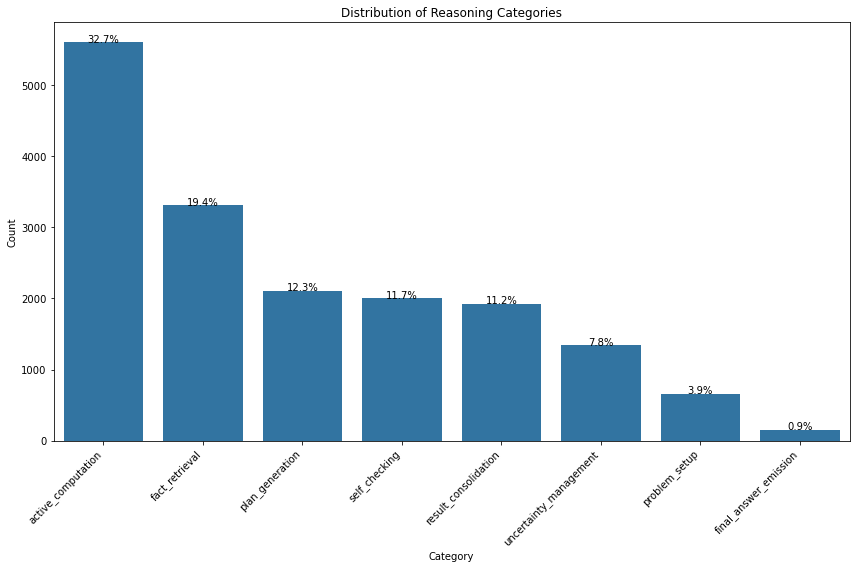

In [15]:
def plot_category_distribution(chunks: List[Dict]):
    """
    Plot the distribution of reasoning categories.
    
    Args:
        chunks: List of chunk dictionaries
    """
    # Count categories
    categories = [chunk['category'] for chunk in chunks]
    category_counts = Counter(categories)
    
    # Sort by frequency
    sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Create DataFrame for plotting
    df = pd.DataFrame(sorted_categories, columns=['Category', 'Count'])
    
    # Calculate percentage
    total = sum(df['Count'])
    df['Percentage'] = df['Count'] / total * 100
    
    # Plot
    plt.figure(figsize=(12, 8), facecolor='white')
    ax = sns.barplot(x='Category', y='Count', data=df)
    ax.set_facecolor('white')
    
    # Add percentage labels
    for i, row in enumerate(df.itertuples()):
        ax.text(i, row.Count + 5, f"{row.Percentage:.1f}%", ha='center')
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Reasoning Categories')
    plt.tight_layout()
    plt.show()
    
    return df

category_distribution = plot_category_distribution(all_chunks)

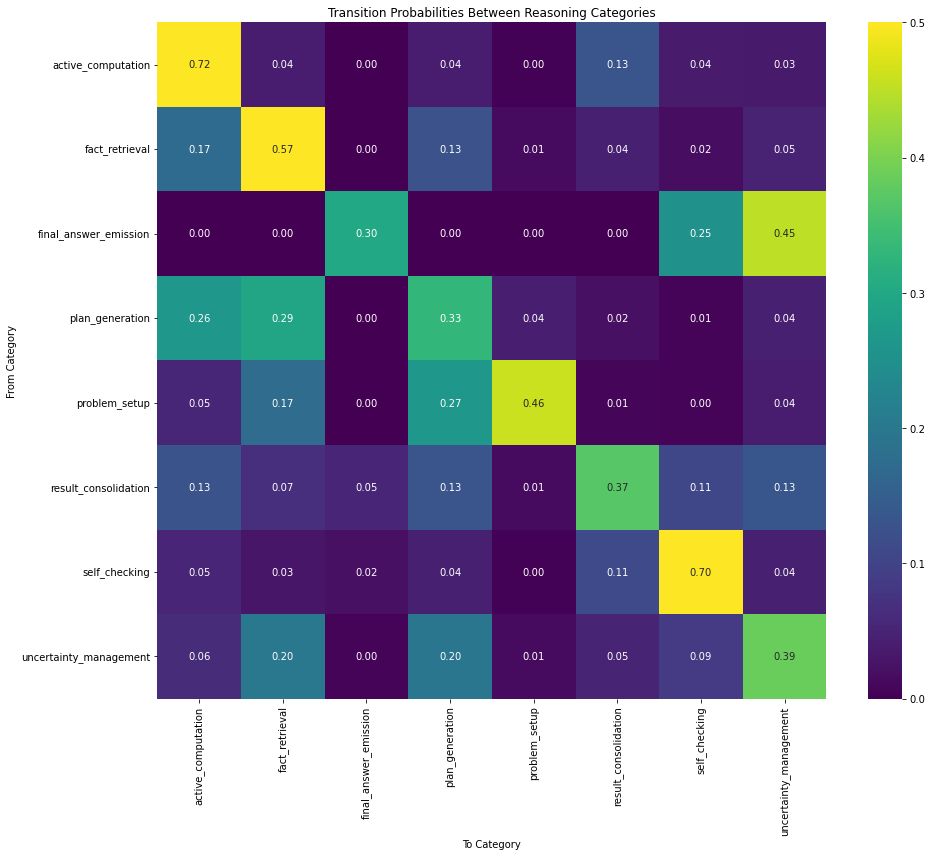

In [17]:
def compute_transition_matrix(chunks: List[Dict]):
    """
    Compute transition matrix between reasoning categories.
    
    Args:
        chunks: List of chunk dictionaries
        
    Returns:
        Transition matrix as DataFrame
    """
    # Get unique categories
    categories = sorted(set(chunk['category'] for chunk in chunks))
    
    # Initialize transition counts
    transitions = defaultdict(Counter)
    
    # Group chunks by problem and seed
    problem_chunks = defaultdict(list)
    for chunk in chunks:
        key = (chunk['problem_id'], chunk['seed'])
        problem_chunks[key].append(chunk)
    
    # Count transitions within each problem
    for key, chunks in problem_chunks.items():
        # Sort chunks by index
        sorted_chunks = sorted(chunks, key=lambda x: x['index'])
        
        # Count transitions
        for i in range(len(sorted_chunks) - 1):
            from_cat = sorted_chunks[i]['category']
            to_cat = sorted_chunks[i + 1]['category']
            transitions[from_cat][to_cat] += 1
    
    # Create transition matrix
    matrix = []
    for from_cat in categories:
        row = []
        total = sum(transitions[from_cat].values())
        for to_cat in categories:
            # Calculate probability if total > 0
            prob = transitions[from_cat][to_cat] / total if total > 0 else 0
            row.append(prob)
        matrix.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(matrix, index=categories, columns=categories)
    
    return df

def plot_transition_matrix(transition_matrix: pd.DataFrame):
    """
    Plot transition matrix as heatmap.
    
    Args:
        transition_matrix: Transition matrix as DataFrame
    """
    plt.figure(figsize=(14, 12), facecolor='white')
    sns.heatmap(
        transition_matrix, 
        annot=True, 
        cmap='viridis', 
        vmin=0, 
        vmax=0.5,  # Cap at 0.5 for better color distribution
        fmt='.2f'
    )
    plt.title('Transition Probabilities Between Reasoning Categories')
    plt.xlabel('To Category')
    plt.ylabel('From Category')
    plt.tight_layout()
    plt.show()

# Compute and plot transition matrix
transition_matrix = compute_transition_matrix(all_chunks)
plot_transition_matrix(transition_matrix)

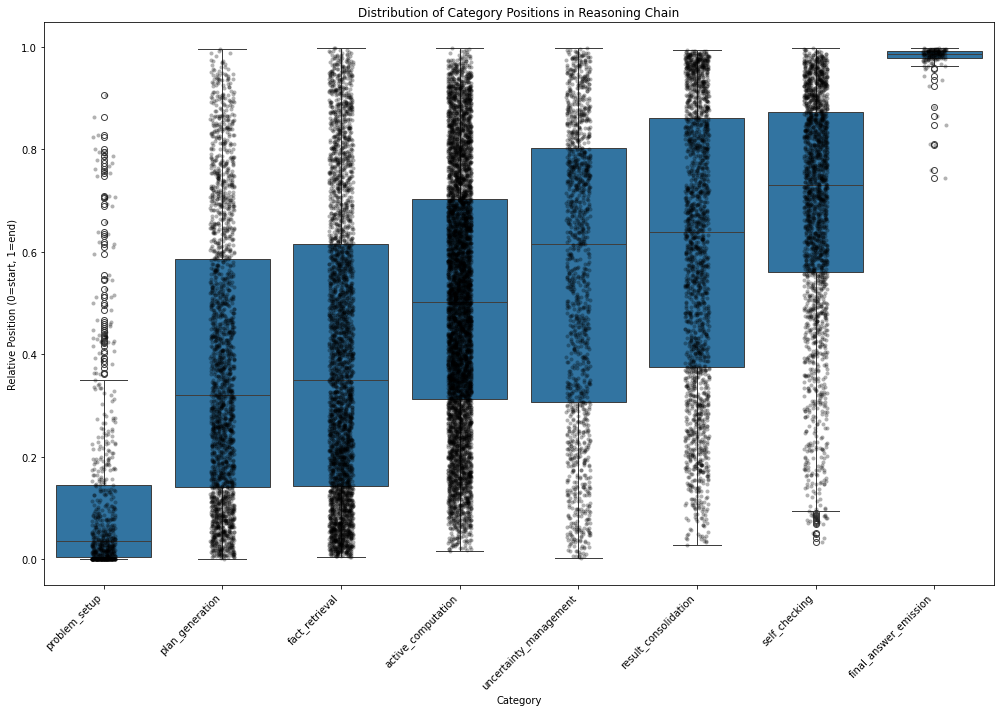

In [18]:
def analyze_category_positions(chunks: List[Dict]):
    """
    Analyze the relative positions of each category in the reasoning chain.
    
    Args:
        chunks: List of chunk dictionaries
        
    Returns:
        DataFrame with position statistics for each category
    """
    # Group by category
    category_positions = defaultdict(list)
    
    for chunk in chunks:
        category = chunk['category']
        position = chunk['relative_position']
        category_positions[category].append(position)
    
    # Calculate statistics
    stats = []
    for category, positions in category_positions.items():
        stats.append({
            'Category': category,
            'Count': len(positions),
            'Mean Position': np.mean(positions),
            'Std Dev': np.std(positions),
            'Min': np.min(positions),
            'Max': np.max(positions),
            '25%': np.percentile(positions, 25),
            '50%': np.percentile(positions, 50),
            '75%': np.percentile(positions, 75)
        })
    
    # Create DataFrame
    df = pd.DataFrame(stats)
    df = df.sort_values('Mean Position')
    
    return df

def plot_category_positions(chunks: List[Dict]):
    """
    Plot the distribution of category positions in the reasoning chain.
    
    Args:
        chunks: List of chunk dictionaries
    """
    # Group by category
    category_positions = defaultdict(list)
    
    for chunk in chunks:
        category = chunk['category']
        position = chunk['relative_position']
        category_positions[category].append(position)
    
    # Create DataFrame for plotting
    data = []
    for category, positions in category_positions.items():
        for pos in positions:
            data.append({'Category': category, 'Relative Position': pos})
    
    df = pd.DataFrame(data)
    
    # Sort categories by mean position
    category_order = df.groupby('Category')['Relative Position'].mean().sort_values().index
    
    # Plot
    plt.figure(figsize=(14, 10), facecolor='white')
    
    # Box plot
    ax = sns.boxplot(
        x='Category', 
        y='Relative Position', 
        data=df, 
        order=category_order
    )
    ax.set_facecolor('white')
    
    # Add scatter points for individual data points
    sns.stripplot(
        x='Category', 
        y='Relative Position', 
        data=df, 
        order=category_order,
        size=4, 
        color='black', 
        alpha=0.3
    )
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Category Positions in Reasoning Chain')
    plt.ylabel('Relative Position (0=start, 1=end)')
    plt.tight_layout()
    plt.show()
    
    # Return statistics
    return analyze_category_positions(chunks)

# Analyze and plot category positions
position_stats = plot_category_positions(all_chunks)

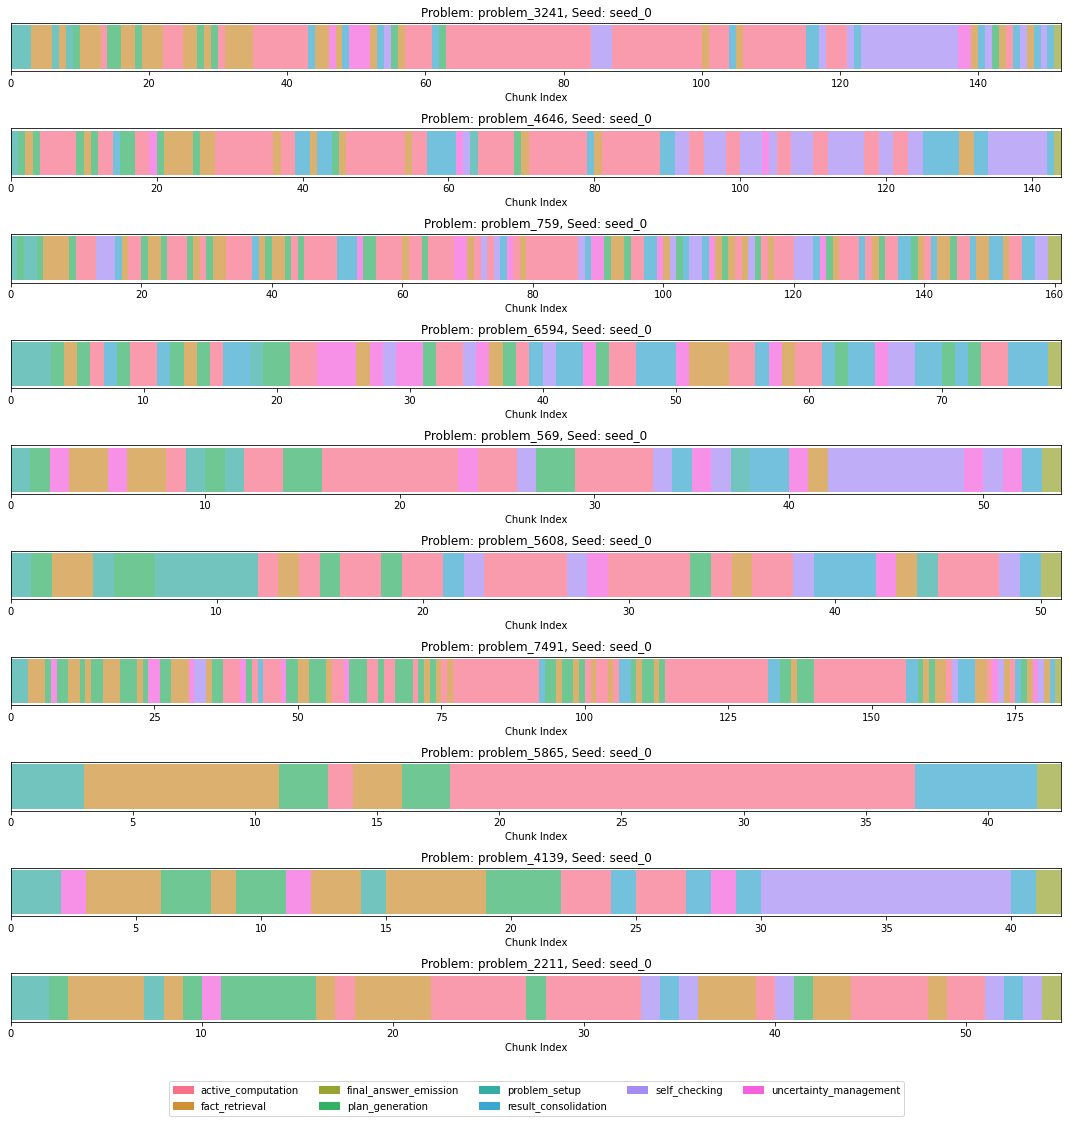

In [19]:
def visualize_category_sequences(chunks: List[Dict], max_problems: int = 10):
    """
    Visualize the sequence of categories for each problem.
    
    Args:
        chunks: List of chunk dictionaries
        max_problems: Maximum number of problems to visualize
    """
    # Get unique categories and assign colors
    categories = sorted(set(chunk['category'] for chunk in chunks))
    color_map = dict(zip(categories, sns.color_palette("husl", len(categories))))
    
    # Group chunks by problem and seed
    problem_chunks = defaultdict(list)
    for chunk in chunks:
        key = (chunk['problem_id'], chunk['seed'])
        problem_chunks[key].append(chunk)
    
    # Select a subset of problems
    selected_problems = random.sample(list(problem_chunks.keys()), max_problems)
    
    # Create figure
    fig, axes = plt.subplots(len(selected_problems), 1, figsize=(15, len(selected_problems) * 1.5))
    if len(selected_problems) == 1:
        axes = [axes]
    
    # Plot each problem
    for i, (key, ax) in enumerate(zip(selected_problems, axes)):
        problem_id, seed = key
        prob_chunks = sorted(problem_chunks[key], key=lambda x: x['index'])
        
        # Create colored blocks for each category
        for j, chunk in enumerate(prob_chunks):
            category = chunk['category']
            ax.barh(0, 1, left=j, color=color_map[category], alpha=0.7)
            
        # Set labels
        ax.set_yticks([])
        ax.set_xlabel('Chunk Index')
        ax.set_title(f'Problem: {problem_id}, Seed: {seed}')
        ax.set_xlim(0, len(prob_chunks))
    
    # Create legend
    handles = [plt.Rectangle((0,0),1,1, color=color_map[cat]) for cat in categories]
    fig.legend(handles, categories, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=min(5, len(categories)), frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

# Visualize category sequences
visualize_category_sequences(all_chunks)

In [54]:
PLOT_COSINE, PRINT_TABLES, SHOW_PROGRESS = False, False, False
    
def create_combined_metrics_df(analysis_dir: Path, layer: int = layer, head: int = head):
    """
    Create a combined DataFrame with correlation, attention, and cosine similarity data.
    
    Args:
        analysis_dir: Path to the analysis directory
    
    Returns:
        DataFrame with all metrics
    """
    # Store data for all problems
    all_data = []
    
    loop = tqdm if SHOW_PROGRESS else lambda x: x
    
    # Iterate through all problem directories
    for problem_dir in loop([d for d in analysis_dir.iterdir() if d.is_dir()]):
        problem_id = problem_dir.name
        
        # Iterate through seed directories
        for seed_dir in [d for d in problem_dir.iterdir() if d.is_dir()]:
            seed = seed_dir.name
            
            # Check if all matrices exist
            correlation_path = seed_dir / f"correlation_matrix_{layer}_{head}.npy"
            attention_path = seed_dir / f"attention_matrix_{layer}_{head}.npy"
            chunks_path = seed_dir / "chunks_dag_improved.json"
            
            if (correlation_path.exists() and attention_path.exists() and chunks_path.exists()):    
                # Load matrices
                correlation_matrix = np.load(correlation_path)
                attention_matrix = np.load(attention_path)
                
                # Load chunks data to get categories
                with open(chunks_path, 'r', encoding='utf-8') as f:
                    chunks_data = json.load(f)
                
                # Extract categories
                categories = [chunk.get('category', 'Unknown') for chunk in chunks_data]
                
                # Get matrix dimensions
                n = len(correlation_matrix)
                
                # Store the raw attention matrix for reference
                raw_attention = attention_matrix.copy()
                
                # Collect data for each pair of chunks
                for i in range(n):
                    for j in range(n):
                        if categories[i].lower() != "unknown" and categories[j].lower() != "unknown":
                            try:
                                all_data.append({
                                    'problem_id': problem_id,
                                    'seed': seed,
                                    'chunk_i': i,
                                    'chunk_j': j,
                                    'category_i': categories[i],
                                    'category_j': categories[j],
                                    'correlation': correlation_matrix[i, j],
                                    'attention': attention_matrix[i, j],
                                    'raw_attention': raw_attention[i, j]
                                })
                            except Exception as e:
                                pass
    
    # Convert to DataFrame
    combined_df = pd.DataFrame(all_data)
    
    return combined_df

def analyze_category_transitions(df: pd.DataFrame, layer, head):
    """
    Create transition matrices showing average correlation and attention
    between different categories.
    
    Args:
        df: DataFrame with correlation and attention data
    """
    # Get unique categories
    all_categories = sorted(set(df['category_i'].unique()) | set(df['category_j'].unique()))
    
    # Initialize transition matrices
    n_categories = len(all_categories)
    correlation_matrix = np.zeros((n_categories, n_categories))
    attention_sum_matrix = np.zeros((n_categories, n_categories))
    count_matrix = np.zeros((n_categories, n_categories), dtype=int)
    
    # Create category to index mapping
    cat_to_idx = {cat: i for i, cat in enumerate(all_categories)}
    
    # First pass: Count and sum values for each category pair
    for _, row in df.iterrows():
        i = cat_to_idx[row['category_i']]
        j = cat_to_idx[row['category_j']]
        
        correlation_matrix[i, j] += row['correlation']
        attention_sum_matrix[i, j] += row['attention']
        count_matrix[i, j] += 1
        
        # Also add to the symmetric position for correlation (since it's symmetric)
        if i != j:
            correlation_matrix[j, i] += row['correlation']
            count_matrix[j, i] += 1
    
    # Compute average correlation
    with np.errstate(divide='ignore', invalid='ignore'):
        correlation_matrix = np.divide(correlation_matrix, count_matrix, where=count_matrix != 0)
    
    # For attention, we need to normalize by row (source category)
    attention_matrix = np.zeros((n_categories, n_categories))
    
    # Group the dataframe by problem_id, seed, and category_i to normalize attention within each group
    for (prob_id, seed, cat_i), group in df.groupby(['problem_id', 'seed', 'category_i']):
        i = cat_to_idx[cat_i]
        
        # Extract attention values and categories for this group
        for _, row in group.iterrows():
            j = cat_to_idx[row['category_j']]
            attention_matrix[i, j] += row['attention']
    
    # Normalize each row to sum to 1 (each source category's attention distribution)
    row_sums = attention_matrix.sum(axis=1, keepdims=True)
    attention_matrix = np.divide(attention_matrix, row_sums, out=np.zeros_like(attention_matrix), where=row_sums!=0)
    
    # Replace NaNs with zeros
    correlation_matrix = np.nan_to_num(correlation_matrix)
    attention_matrix = np.nan_to_num(attention_matrix)
    
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), facecolor='white')
    axes[0].set_facecolor('white')
    axes[1].set_facecolor('white')
    
    # Plot correlation matrix
    im0 = axes[0].imshow(correlation_matrix, cmap='coolwarm', vmin=np.quantile(correlation_matrix, 0.1), vmax=np.quantile(correlation_matrix, 0.9))
    axes[0].set_title(f"Average Correlation Between Categories, Layer: {layer}, Head: {head}", fontsize=14)
    axes[0].set_xticks(np.arange(n_categories))
    axes[0].set_yticks(np.arange(n_categories))
    axes[0].set_xticklabels(all_categories, rotation=45, ha='right', fontsize=10)
    axes[0].set_yticklabels(all_categories, fontsize=10)
    
    # Add colorbar
    cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cbar0.set_label('Correlation', fontsize=12)
    
    # Add count annotations
    for i in range(n_categories):
        for j in range(n_categories):
            if count_matrix[i, j] > 0:
                text_color = 'white' if abs(correlation_matrix[i, j]) > 0.5 else 'black'
                axes[0].text(j, i, f"{correlation_matrix[i, j]:.2f}\n({count_matrix[i, j]})", ha="center", va="center", color=text_color, fontsize=8)
    
    # Plot attention matrix
    im1 = axes[1].imshow(attention_matrix, cmap='coolwarm', vmin=0, vmax=np.quantile(attention_matrix[attention_matrix > 0], 0.9))
    axes[1].set_title(f"Average Attention From Source to Target Category, Layer: {layer}, Head: {head}", fontsize=14)
    axes[1].set_xticks(np.arange(n_categories))
    axes[1].set_yticks(np.arange(n_categories))
    axes[1].set_xticklabels(all_categories, rotation=45, ha='right', fontsize=10)
    axes[1].set_yticklabels(all_categories, fontsize=10)
    
    # Add colorbar
    cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_label('Attention', fontsize=12)
    
    # Add attention value annotations
    for i in range(n_categories):
        for j in range(n_categories):
            if attention_matrix[i, j] > 0:
                text_color = 'white' if attention_matrix[i, j] > 0.5 else 'black'
                axes[1].text(j, i, f"{attention_matrix[i, j]:.2f}\n({count_matrix[i, j]})", ha="center", va="center", color=text_color, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print tables if requested
    if PRINT_TABLES:
        print("Top 10 Category Pairs by Correlation:")
        top_corr_pairs = []
        for i in range(n_categories):
            for j in range(i, n_categories):  # Only upper triangle to avoid duplicates
                if count_matrix[i, j] >= 5:  # Minimum sample size
                    top_corr_pairs.append((all_categories[i], all_categories[j], correlation_matrix[i, j], count_matrix[i, j]))
        
        top_corr_pairs.sort(key=lambda x: x[2], reverse=True)
        for cat1, cat2, corr, count in top_corr_pairs[:10]:
            print(f"{cat1} → {cat2}: {corr:.3f} (n={count})")
        
        print("\nBottom 10 Category Pairs by Correlation:")
        for cat1, cat2, corr, count in sorted(top_corr_pairs, key=lambda x: x[2])[:10]:
            print(f"{cat1} → {cat2}: {corr:.3f} (n={count})")
        
        print("\nTop 10 Category Pairs by Attention:")
        top_att_pairs = []
        for i in range(n_categories):
            for j in range(n_categories):
                if i != j and count_matrix[i, j] >= 5:  # Minimum sample size, exclude self
                    top_att_pairs.append((all_categories[i], all_categories[j], attention_matrix[i, j], count_matrix[i, j]))
        
        top_att_pairs.sort(key=lambda x: x[2], reverse=True)
        for cat1, cat2, att, count in top_att_pairs[:10]:
            print(f"{cat1} → {cat2}: {att:.3f} (n={count})")
        
    # Return matrices and category list for further analysis
    return {
        'categories': all_categories,
        'correlation': correlation_matrix,
        'attention': attention_matrix,
        'count': count_matrix
    }

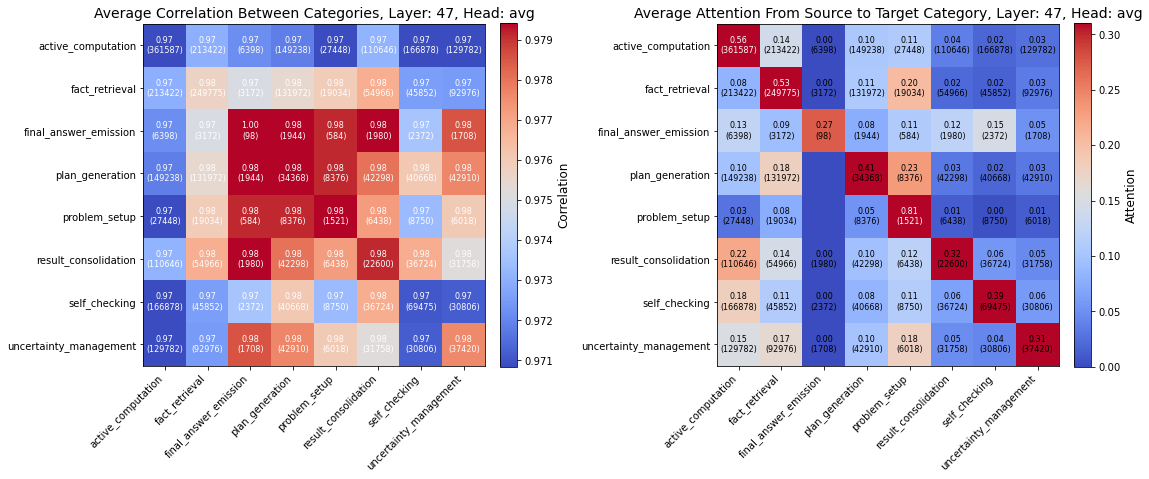

In [43]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='avg')
transition_data = analyze_category_transitions(combined_df)

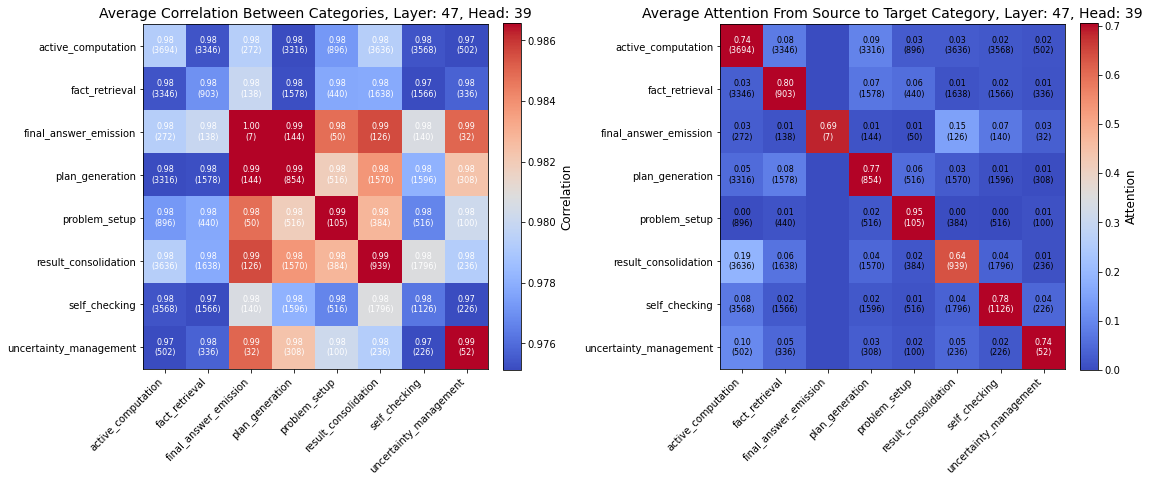

In [55]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='39')
transition_data = analyze_category_transitions(combined_df, layer=47, head='39')

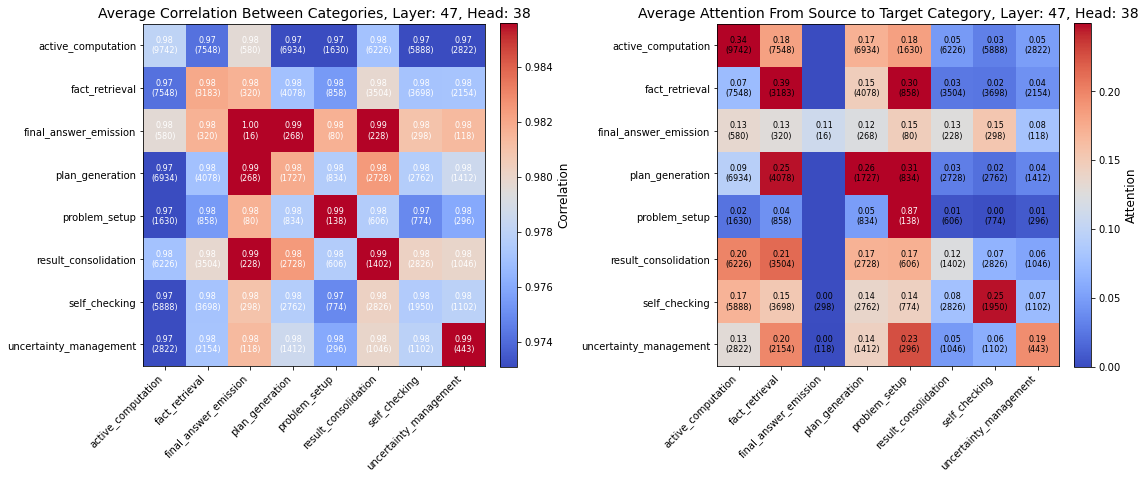

In [57]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='38')
transition_data = analyze_category_transitions(combined_df, layer=47, head='38')

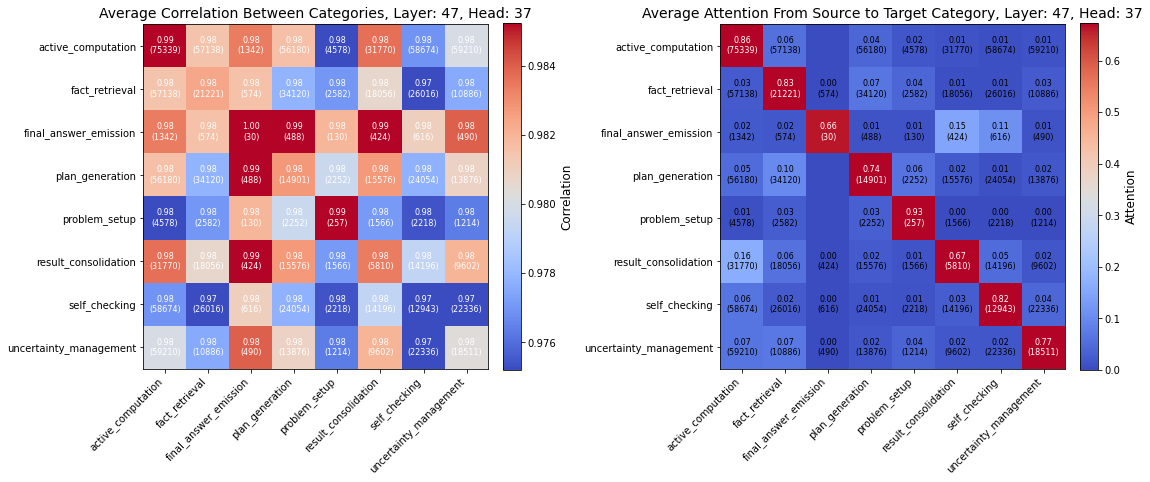

In [58]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='37')
transition_data = analyze_category_transitions(combined_df, layer=47, head='37')

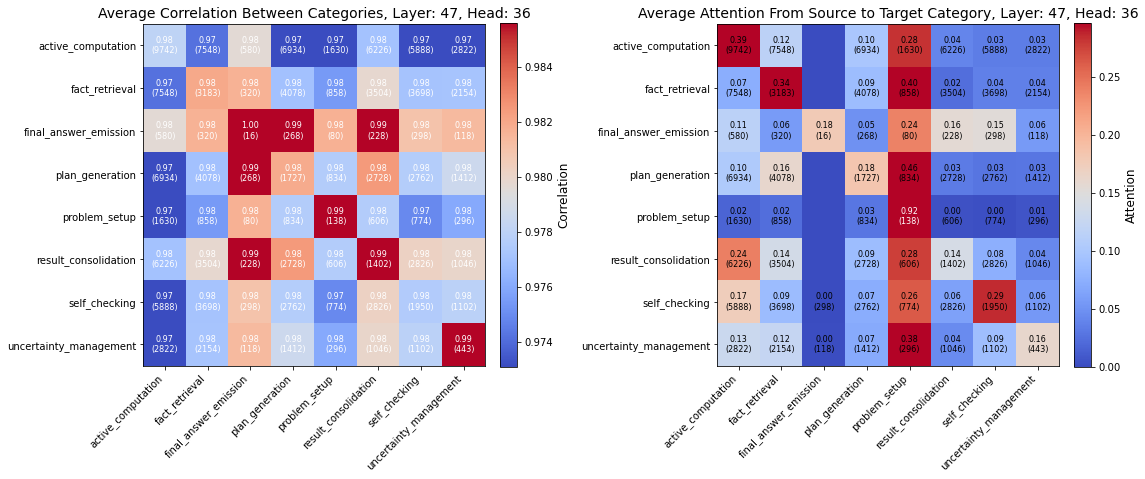

In [56]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='36')
transition_data = analyze_category_transitions(combined_df, layer=47, head='36')

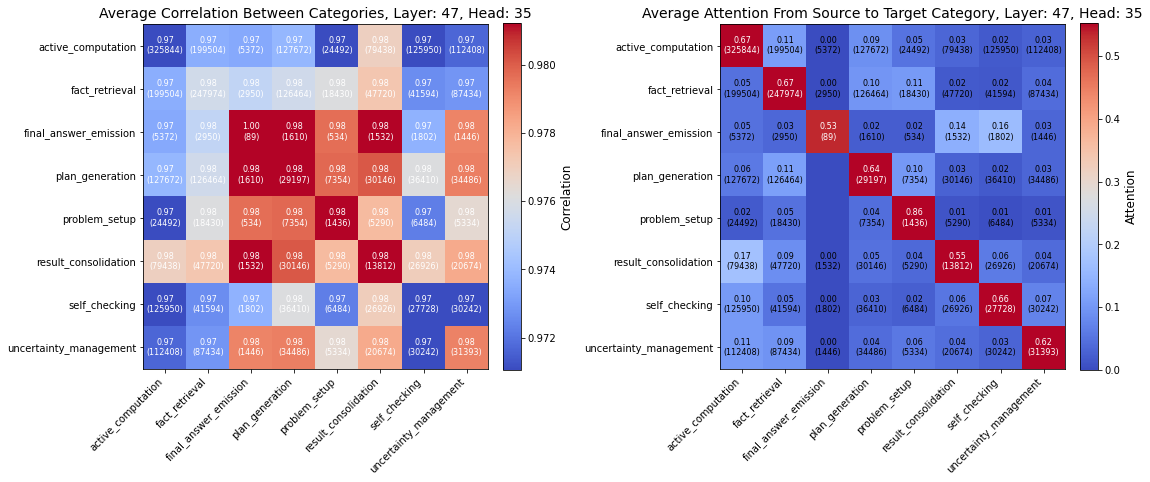

In [59]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='35')
transition_data = analyze_category_transitions(combined_df, layer=47, head='35')

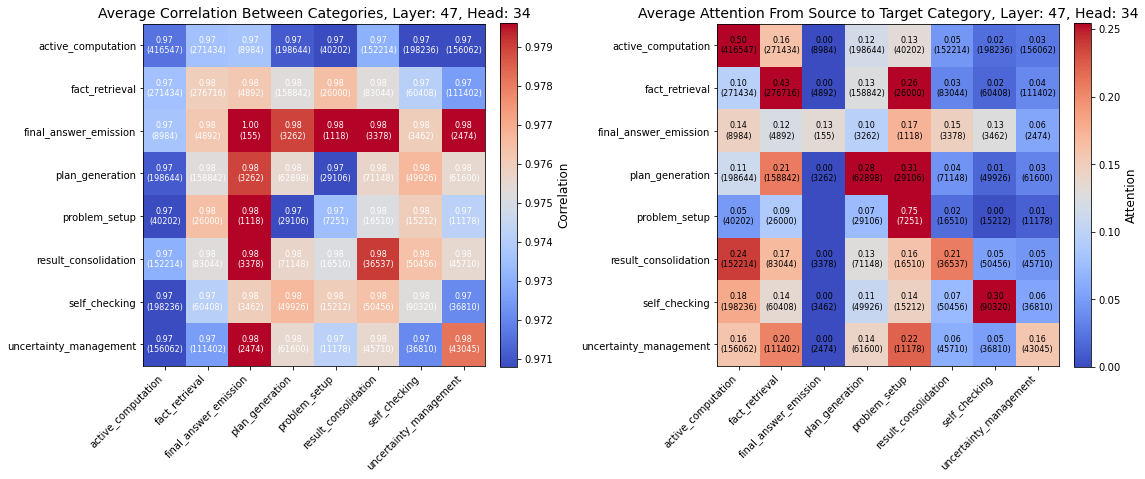

In [60]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='34')
transition_data = analyze_category_transitions(combined_df, layer=47, head='34')

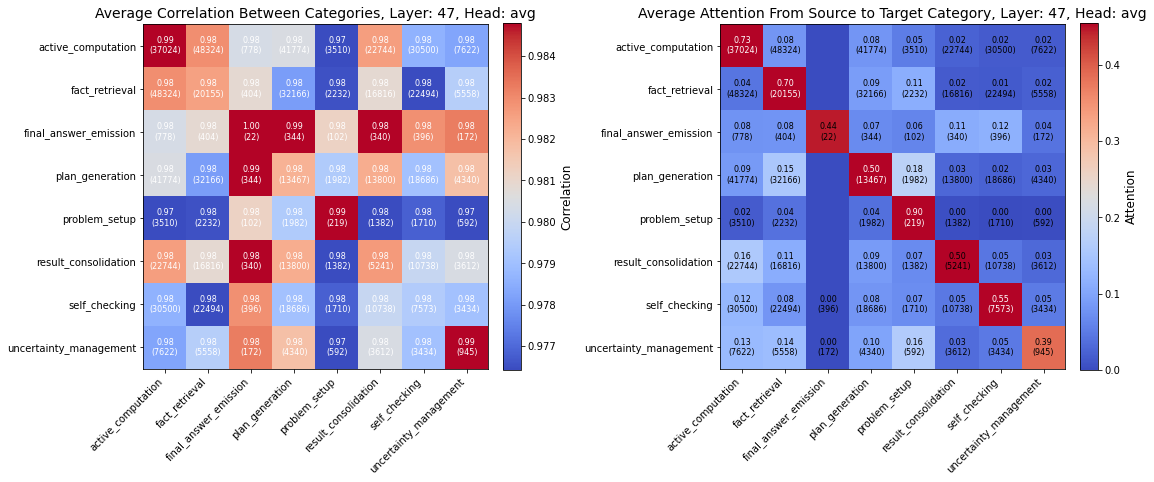

In [47]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='24')
transition_data = analyze_category_transitions(combined_df)

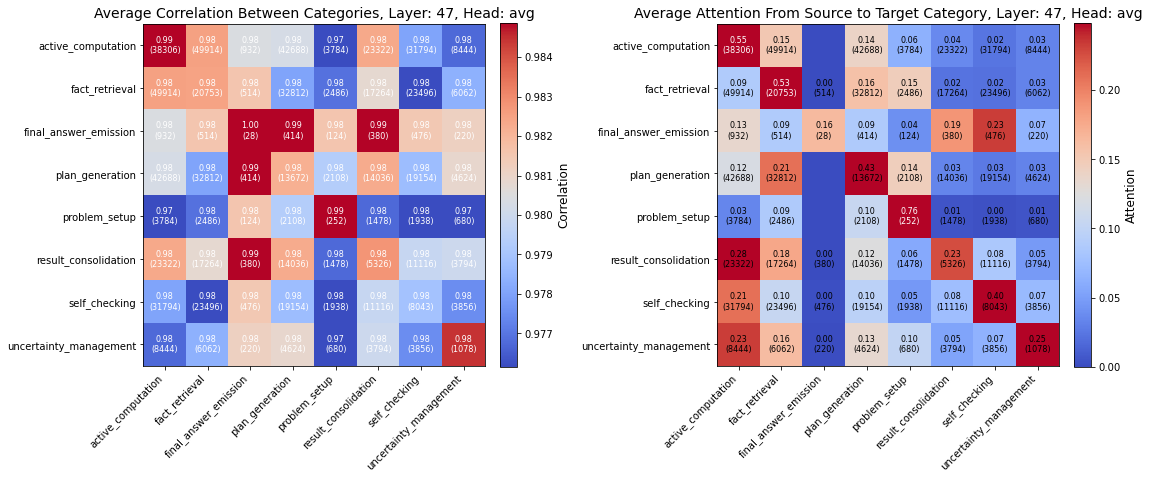

In [45]:
combined_df = create_combined_metrics_df(analysis_dir, layer=47, head='12')
transition_data = analyze_category_transitions(combined_df)

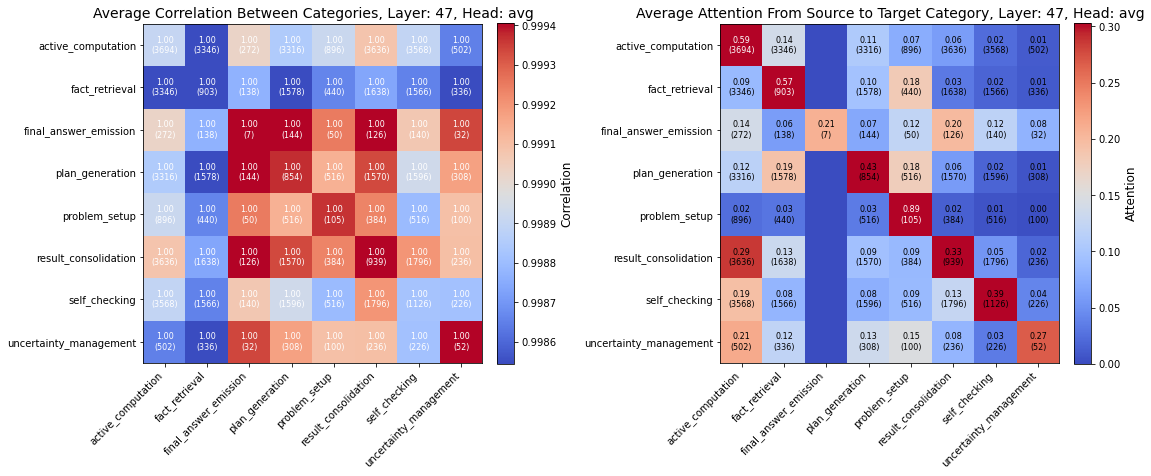

In [39]:
combined_df = create_combined_metrics_df(analysis_dir, layer=36, head='avg')
transition_data = analyze_category_transitions(combined_df)

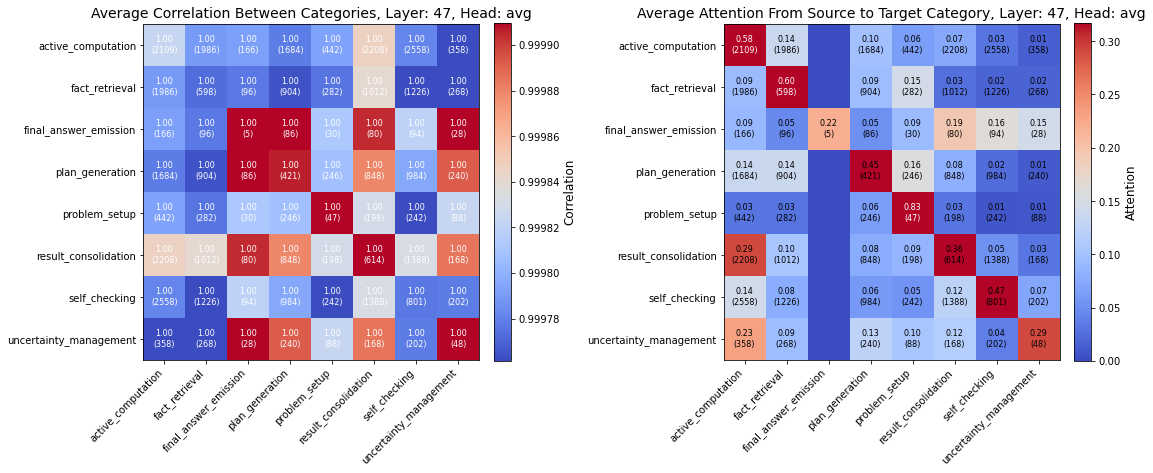

In [38]:
combined_df = create_combined_metrics_df(analysis_dir, layer=24, head='avg')
transition_data = analyze_category_transitions(combined_df)

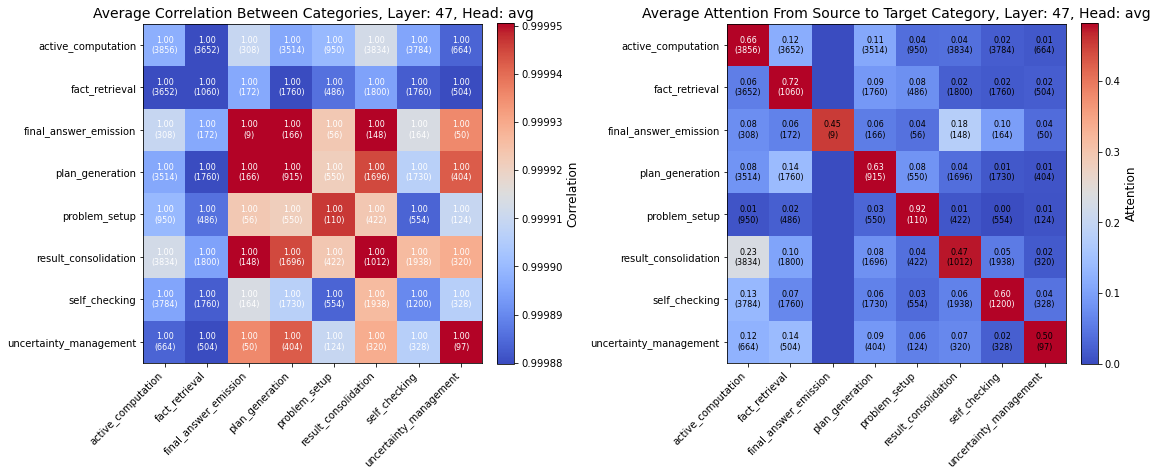

In [37]:
combined_df = create_combined_metrics_df(analysis_dir, layer=12, head='avg')
transition_data = analyze_category_transitions(combined_df)

In [ ]:
def analyze_activation_patching_results(results_dir: str = "activation_patching_results", max_chunks: int = 12):
    """
    Analyze results from activation patching experiments.
    
    Args:
        results_dir: Directory containing activation patching results
    """
    # Find all problem directories
    problem_dirs = [d for d in glob.glob(os.path.join(results_dir, "problem_*_seed_*")) if os.path.isdir(d)]
    
    if not problem_dirs:
        print(f"No problem directories found in {results_dir}")
        return
    
    print(f"Found {len(problem_dirs)} problem directories")
    
    # Collect all result files
    all_results = []
    for problem_dir in problem_dirs:
        result_files = glob.glob(os.path.join(problem_dir, "patch_results_chunks*.json"))
        for result_file in result_files:
            num_chunks = len(result_file.split("chunks")[1].split("_"))
            if num_chunks > max_chunks:
                continue
            try:
                with open(result_file, 'r') as f:
                    result = json.load(f)
                    if result.get("answers_differ", False):  # Only include results where answers differ
                        all_results.append(result)
            except Exception as e:
                print(f"Error reading {result_file}: {e}")
    
    print(f"Found {len(all_results)} experiment results with differing answers")
    
    if not all_results:
        print("No valid results found")
        return
    
    # Extract all layers that were patched
    all_layers = set()
    for result in all_results:
        all_layers.update(map(int, result.get("answer_match", {}).keys()))
    
    all_layers = sorted(all_layers)
    print(f"Layers patched: {all_layers}")
    
    # Calculate success rate by layer
    success_by_layer = defaultdict(list)
    for result in all_results:
        for layer_str, match in result.get("answer_match", {}).items():
            success_by_layer[int(layer_str)].append(1 if match else 0)
    
    # Calculate aggregate success rate
    aggregate_success = {
        layer: np.mean(successes) if successes else 0
        for layer, successes in success_by_layer.items()
    }
    
    # Calculate success rate by category
    category_success = defaultdict(lambda: defaultdict(list))
    for result in all_results:
        categories = result.get("target_chunk_categories", [])
        if not categories:
            continue
            
        # Use the first category for simplicity (or could use a combined key)
        category = categories[0]
        
        for layer_str, match in result.get("answer_match", {}).items():
            category_success[category][int(layer_str)].append(1 if match else 0)
    
    # Calculate aggregate success rate by category
    aggregate_category_success = {
        category: {
            layer: np.mean(successes) if successes else 0
            for layer, successes in layer_success.items()
        }
        for category, layer_success in category_success.items()
    }
    
    # Create visualization of aggregate results
    plt.figure(figsize=(12, 6))
    
    # Sort layers for plotting
    sorted_layers = sorted(aggregate_success.keys())
    success_rates = [aggregate_success[layer] for layer in sorted_layers]
    
    plt.bar(sorted_layers, success_rates, color='blue', alpha=0.7)
    plt.xlabel("Layer", fontsize=12)
    plt.ylabel("Success Rate", fontsize=12)
    plt.title("Aggregate Success Rate by Layer", fontsize=14)
    plt.grid(alpha=0.3)
    plt.xticks(sorted_layers)
    
    # Add a horizontal line at 0.5 for reference
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% Success')
    
    # Add text labels for the success rates
    for i, layer in enumerate(sorted_layers):
        plt.text(layer, success_rates[i] + 0.02, f"{success_rates[i]:.2f}", ha='center', va='bottom', fontsize=10)
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Create visualization by category
    categories = list(aggregate_category_success.keys())
    if len(categories) > 1:  # Only create this plot if we have multiple categories
        plt.figure(figsize=(14, 8))
        
        # Create a DataFrame for easier plotting
        category_data = []
        for category, layer_success in aggregate_category_success.items():
            for layer, success_rate in layer_success.items():
                category_data.append({
                    'Category': category,
                    'Layer': layer,
                    'Success Rate': success_rate,
                    'Sample Size': len(category_success[category][layer])
                })
        
        category_df = pd.DataFrame(category_data)
        
        # Plot success rate by category and layer
        for i, category in enumerate(categories):
            category_df_filtered = category_df[category_df['Category'] == category]
            if not category_df_filtered.empty:
                plt.plot(
                    category_df_filtered['Layer'], 
                    category_df_filtered['Success Rate'],
                    marker='o',
                    linewidth=2,
                    label=f"{category} (n={category_df_filtered['Sample Size'].iloc[0]})"
                )
        
        plt.xlabel("Layer", fontsize=12)
        plt.ylabel("Success Rate", fontsize=12)
        plt.title("Success Rate by Category and Layer", fontsize=14)
        plt.grid(alpha=0.3)
        plt.xticks(sorted_layers)
        plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% Success')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total experiments: {len(all_results)}")
    print(f"Average success rate across all layers: {np.mean(list(aggregate_success.values())):.3f}")
    
    # Find best performing layers
    best_layers = sorted(aggregate_success.items(), key=lambda x: x[1], reverse=True)[:5]
    print("\nTop 5 best performing layers:")
    for layer, success_rate in best_layers:
        print(f"Layer {layer}: {success_rate:.3f}")
    
    # Print category statistics if available
    if categories:
        print("\nCategory Statistics:")
        for category in categories:
            category_rates = list(aggregate_category_success[category].values())
            if category_rates:
                print(f"{category}: Avg success rate = {np.mean(category_rates):.3f}, Sample size = {len(category_success[category][sorted_layers[0]])}")
    
    return {
        'aggregate_success': aggregate_success,
        'category_success': aggregate_category_success,
        'all_results': all_results
    }

# Run the analysis
patching_results = analyze_activation_patching_results("activation_patching_results", 16)